# Import, Init

In [14]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, "./classes/")
import cls_nnetwork

# reloading functions without runtime.restart
import importlib
importlib.reload(cls_nnetwork)

<module 'cls_nnetwork' from './classes/cls_nnetwork.py'>

In [15]:
# cut -- train test data with trimmed columns, so that it's more easy to train

nn_manager_cut = cls_nnetwork.NeuralManager(dir_path='../data/csv_to_train/train_test_cut/')

>>> train-test inited:  {'y_test': True, 'X_test': True, 'y_train': True, 'X_train': True}


# Preparing data

## Normalizing

In [16]:
from sklearn.preprocessing import RobustScaler

nn_manager_cut.normalize_X(scaler=RobustScaler)

nn_manager_cut.X_train_normalized[:2]

array([[-0.35788468, -0.36106367, -0.36592223, -0.58401698, -0.43077291,
        -0.28358634, -0.82919494, -0.64760888,  2.76317136,  0.03411234,
        -0.32110596, -0.22554355],
       [-0.35778409, -0.36106367, -0.36592223, -0.57780875, -0.43056673,
        -0.28358294, -0.83411168, -0.65625833,  1.16726343,  0.00787208,
        -0.32110596, -0.23042704]])

## Unrolling data to sequences
[[to #Model-fit]](#Model-fit)

In [17]:
sequence_len = 4

nn_manager_cut.unroll_train_test_to_sequences(sequence_len=sequence_len)

In [18]:
nn_manager_cut.X_test_unrolled[1]

array([[ 4.5733397 ,  4.5467675 ,  4.82022174, 10.20613854,  1.28184017,
         1.87952864, -0.04548318,  2.5474734 , -0.23836317,  3.31316113,
         1.30698295,  1.48368537],
       [ 4.68146956,  4.71168578,  4.88345446, 11.4789522 ,  1.24140549,
         1.88162712, -0.27668704,  1.59950791, -0.40613811, -3.6198442 ,
         2.99879035,  1.35947304],
       [ 4.71778107,  4.73227616,  4.97448411, 10.07373856,  1.14087063,
         1.88357335, -0.2339349 ,  1.7297756 ,  0.08286445,  2.8703567 ,
         2.62804179,  1.32794069],
       [ 4.84592753,  4.81141742,  5.00291762, 11.17550917,  1.25063089,
         1.88548092,  0.26145216,  2.98612256, -0.25882353, -4.69241492,
         7.17938889,  1.42051883]])

In [19]:
# goes up by one sequence -- compare this cell result vs previous
nn_manager_cut.X_test_unrolled[2]

array([[ 4.68146956,  4.71168578,  4.88345446, 11.4789522 ,  1.24140549,
         1.88162712, -0.27668704,  1.59950791, -0.40613811, -3.6198442 ,
         2.99879035,  1.35947304],
       [ 4.71778107,  4.73227616,  4.97448411, 10.07373856,  1.14087063,
         1.88357335, -0.2339349 ,  1.7297756 ,  0.08286445,  2.8703567 ,
         2.62804179,  1.32794069],
       [ 4.84592753,  4.81141742,  5.00291762, 11.17550917,  1.25063089,
         1.88548092,  0.26145216,  2.98612256, -0.25882353, -4.69241492,
         7.17938889,  1.42051883],
       [ 4.91784646,  4.75803855,  5.03973264,  9.35599126,  1.29602355,
         1.88750198,  0.62933247,  2.55033297, -0.37953964,  1.75284953,
         3.00180661,  1.30012297]])

In [20]:
# on the base of the first two elements of the sequence we want to predict the third's day price

nn_manager_cut.y_test.iloc[:6], nn_manager_cut.y_test_unrolled[:6]

(             Price
 Date              
 2019-04-04  4902.4
 2019-04-05  5010.2
 2019-04-06  5046.2
 2019-04-07  5173.6
 2019-04-08  5245.2
 2019-04-09  5158.4,
 array([[5245.2],
        [5158.4],
        [5307.8],
        [5022.6],
        [5054.2],
        [5051.8]]))

# Model

## Model Assembling

[n_seq-n_steps in MLM example elaboration](z_MlMastery%20LSTM%20for%20TS%20.ipynb#n_seq-n_steps)<br>
(We can parameterize this and define the number of subsequences as n_seq and the number of time steps per subsequence as n_steps. [[source]](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=We%20can%20parameterize%20this%20and))

### Architectures

#### CNN LSTM shape

In [21]:
from tensorflow.keras.layers import (
    LeakyReLU,
    TimeDistributed, 
    Conv1D, 
    MaxPooling1D, 
    Flatten, 
    LSTM, 
    Bidirectional,
    Dense, 
    Dropout, 
    BatchNormalization)
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from tensorflow.keras import regularizers

n_steps_subseq = 2
n_seq = 2
n_features = nn_manager_cut.X_train.shape[1]

# CNN-LSTM
shape_cnn_lstm_train = dict(
            n_rows=nn_manager_cut.X_train_unrolled.shape[0], 
            n_seq=n_seq, 
            n_steps_subseq=n_steps_subseq, 
            n_features=n_features)

shape_cnn_lstm_test = {key:(value if key != 'n_rows' else nn_manager_cut.X_test_unrolled.shape[0]) 
                       for (key, value) in shape_cnn_lstm_train.items()}
(shape_cnn_lstm_train, shape_cnn_lstm_test)

({'n_rows': 3178, 'n_seq': 2, 'n_steps_subseq': 2, 'n_features': 12},
 {'n_rows': 791, 'n_seq': 2, 'n_steps_subseq': 2, 'n_features': 12})

#### Stacked LSTM shape
[[#Setting General seq len for X_* unrolling]](#Unrolling-data-to-sequences)

In [22]:
# Stacked LSTM 
shape_lstm_stacked_train = dict(
            n_rows=nn_manager_cut.X_train_unrolled.shape[0], 
            n_seq=sequence_len, 
            n_features=n_features) # not splitting to subseq

shape_lstm_stacked_test = {key:(value if key != 'n_rows' else nn_manager_cut.X_test_unrolled.shape[0]) 
                       for (key, value) in shape_lstm_stacked_train.items()}

(shape_lstm_stacked_train, shape_lstm_stacked_test)

({'n_rows': 3178, 'n_seq': 4, 'n_features': 12},
 {'n_rows': 791, 'n_seq': 4, 'n_features': 12})

#### CNN-LSTM Layers

In [23]:
# CNN-LSTM Architecture

weights_init = GlorotNormal()

conv1D_0 = Conv1D(filters=64, kernel_size=1, activation='relu', padding='same', kernel_initializer=weights_init)
conv1D_1 = Conv1D(filters=64, kernel_size=1, activation='relu', padding='same')
# conv1D_2 = Conv1D(filters=64, kernel_size=1, activation='relu', padding='causal')
# conv1D_3 = Conv1D(filters=64, kernel_size=1, activation='relu', padding='causal')

# src: 
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=A%20convolutional%20neural
template_CNN_LSTM = [
    TimeDistributed(conv1D_0, input_shape=(None, shape_cnn_lstm_train['n_steps_subseq'], shape_cnn_lstm_train['n_features'])),
    TimeDistributed(conv1D_1),
#     TimeDistributed(conv1D_2),
#     TimeDistributed(conv1D_3),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    LSTM(50, activation='relu', return_sequences = True),
    LSTM(50, activation='relu'),
    Dense(50),
    Dense(20),
    Dense(1)
]

#### LSTM-based
[[Unrolling Seq Len]](#Unrolling-data-to-sequences)<br>
[[to #Model-fit]](#Model-fit)

In [24]:
input_model_shape=(shape_lstm_stacked_train['n_seq'], shape_lstm_stacked_train['n_features'])
input_model_shape

(4, 12)

In [25]:
# Stacked LSTM

weights_init = GlorotNormal()

template_Stacked_LSTM = [
    Bidirectional(
        LSTM(10, activation=LeakyReLU(alpha=0.35), 
             kernel_initializer=weights_init, 
#              return_sequences=True,
            ),
         input_shape=input_model_shape),
#     ),
#     LSTM(50, activation='relu', return_sequences=True),    
#     LSTM(10, activation=keras.layers.LeakyReLU(alpha=0.3)),    
#     Dense(50),
#     Dense(10),
#     Dense(5),
#     Dense(2),
    Dense(1)
]

In [26]:
nn_manager_cut.X_train_unrolled.shape

(3178, 4, 12)

### Compiling Model with the chosen Architecture

In [27]:
# Assembling and compiling model

from tensorflow import keras

opt_adam = keras.optimizers.Adam(
    learning_rate=3e-5, #wo BatchNorm
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False, 
)

training_params = dict(optimizer=opt_adam, loss=keras.losses.Huber(delta=.5), metrics=['mae'])


nn_manager_cut.model_combine(template=template_Stacked_LSTM, compile_dict=training_params)

>>> model compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 20)                1840      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 21        
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
_________________________________________________________________


True

## Model Training

In [28]:
# CNN-LSTMs DataShapes
data_shape_cnn_lstm_train = (
    shape_cnn_lstm_train['n_rows'], 
    shape_cnn_lstm_train['n_seq'], 
    shape_cnn_lstm_train['n_steps_subseq'],
    shape_cnn_lstm_train['n_features']
)
data_shape_cnn_lstm_test = (
    shape_cnn_lstm_test['n_rows'], 
    shape_cnn_lstm_test['n_seq'], 
    shape_cnn_lstm_test['n_steps_subseq'],
    shape_cnn_lstm_test['n_features']
)
(data_shape_cnn_lstm_train, data_shape_cnn_lstm_test)

((3178, 2, 2, 12), (791, 2, 2, 12))

In [29]:
# LSTMs Stacked DataShapes
data_shape_lstm_stacked_train = (
    shape_lstm_stacked_train['n_rows'], 
    shape_lstm_stacked_train['n_seq'],
    shape_cnn_lstm_train['n_features']
)
data_shape_lstm_stacked_test = (
    shape_cnn_lstm_test['n_rows'], 
    shape_lstm_stacked_train['n_seq'],
    shape_cnn_lstm_test['n_features']
)
(data_shape_lstm_stacked_train, data_shape_lstm_stacked_test)

((3178, 4, 12), (791, 4, 12))

#### Model fit

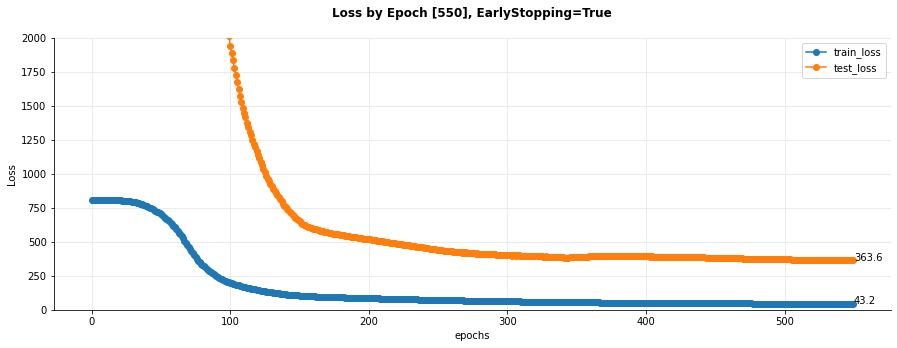

In [30]:
# %%time
nn_manager_cut.model_fit(n_epoch=550,
                           data_shape_train=data_shape_lstm_stacked_train,
                           data_shape_test=data_shape_lstm_stacked_test,
                           verbose=0, 
                           return_results=True, 
                           print_charts=True,
                           early_stopping=True
                        );
plt.ylim(0,2e3);

Architectures: <br>
[[#CNN-LSTM_Architecture]](#CNN-LSTM-Layers)<br>
[[#Stacked-LSTM_Architecture]](#LSTM-based)

Model Compiling setup [[go]](#Compiling-Model-with-the-chosen-Architecture)<br>
Unrolling Seq Len [[go]](#Unrolling-data-to-sequences)<br>

# Saving Model

In [35]:
from datetime import datetime

nn_manager_cut.model.save(f'./saved_models/{datetime.now().strftime("%Y%m%d_%HH%MM%SS")}_363_Bidi')

INFO:tensorflow:Assets written to: ./saved_models/20210619_18H21M36S_363_Bidi/assets


INFO:tensorflow:Assets written to: ./saved_models/20210619_18H21M36S_363_Bidi/assets


# Prediction

In [32]:
# nn_manager_cut.X_test_unrolled[0].shape

In [33]:
# ind_t_X = 0
# ind_t_y = ind_t_X + 2

# nn_manager_cut.model.predict(nn_manager_cut.X_test_unrolled[ind_t_X].reshape(1,2,12)), nn_manager_cut.y_test.iloc[ind_t_y]

In [34]:
# nn_manager_cut.y_test.plot(figsize=(15,5))
# TODO: reverse order of dates